In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
from astropy.io import fits
from scipy import interpolate
import pandas as pd

plt.style.use('light_mode')

In [2]:
DATA_DIR = '/Users/darbymccauley/coursework/ast503_2024_Fall/homework/darby_mccauley/data/hw1_data'

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this assignment is to:
- get comfortable with photon energy, frequency, and wavelength - calculate power and luminosity
- know now to convert magnitudes, fluxes, photon counts.
- start basic Python scripts and plotting

# Q1. Make plot of the electromagnetic spectrum using Python. (30 pts)
- Your plot should have multiple x-axes - one for wavelength (in meters), one for frequency (in Hz), one for energy (in eV)
    (hint: `gridspec` or `subplots` in general can be used to do this. See if you can find something useful here: https://matplotlib.org/stable/gallery/index) (10 pts)
- axes should be lograthmic, and each of these axes should have ticklabels that are exponential above or below (5 pts)
- the wavelength axes should also have more conventional SI units for km, mm, micron, nm, Angstrom, and picometer labelled (5 pts)
- label each region of the EM spectrum (10 pts)

 Something like this: 

<img src="https://aktinovolia.com/wp-content/uploads/aktinovolia.com-radiation-chart-electromagnetic-spectrum-rf-em-spectrum-rf-electromagnetic-3-.jpg">

or (except you should have energy too) 

<img src="https://multiphaseism.wordpress.com/wp-content/uploads/2013/05/electromagnetic_spectrum.jpg">

# Remember to save your script. Stay organized. You will be reusing code.

You are encouraged to add your own flourishes to the plot.
Joseph is empowered to give out 5 points as he sees fit for aesthetics. 

Keep this plot handy. You should be able to intuitively convert between these values in your head. 

In [3]:
c = 3e8 # [m/s]
h = (4.13e-15) # [eV/Hz]

freqs = np.logspace(8, 22, 10000, endpoint=True)
wavelengths = c/freqs
energies = h*freqs

def increasing_wave(x):
    b = 0.15
    a = 10**1.1
    wave = np.sin(x**b / a)
    return wave

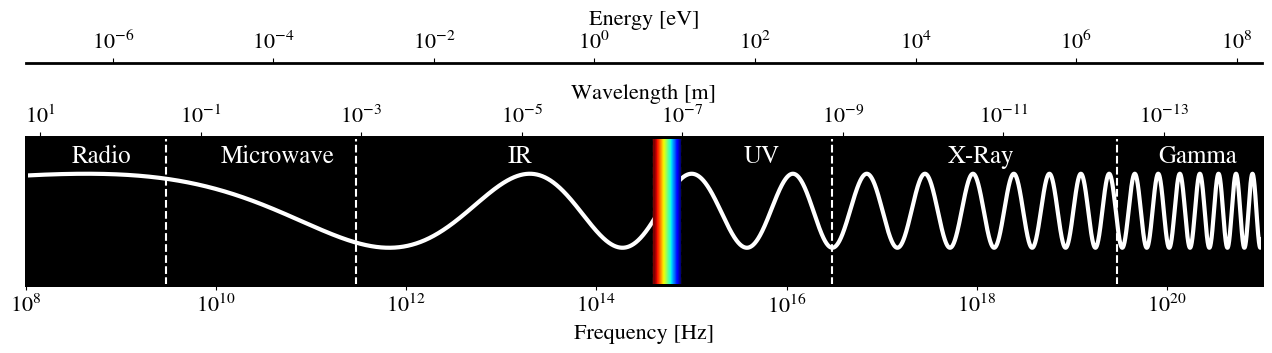

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

axes.vlines(3e19, -2, 2, color='w', linestyle='dashed')
axes.vlines(3e16, -2, 2, color='w', linestyle='dashed')
axes.vlines(7.5e14, -2, 2, color='w', linestyle='dashed') #, zorder=4)
axes.vlines(4e14, -2, 2, color='w', linestyle='dashed') #, zorder=4)
axes.vlines(3e11, -2, 2, color='w', linestyle='dashed')
axes.vlines(3e9, -2, 2, color='w', linestyle='dashed')

axes.text(0.98, 0.95, 'Gamma', horizontalalignment='right',
          verticalalignment='top', transform=axes.transAxes, fontsize=18, color='w')
axes.text(0.8, 0.95, 'X-Ray', horizontalalignment='right',
          verticalalignment='top', transform=axes.transAxes, fontsize=18, color='w')
axes.text(0.61, 0.95, 'UV', horizontalalignment='right',
          verticalalignment='top', transform=axes.transAxes, fontsize=18, color='w')
axes.text(0.41, 0.95, 'IR', horizontalalignment='right',
          verticalalignment='top', transform=axes.transAxes, fontsize=18, color='w')
axes.text(0.25, 0.95, 'Microwave', horizontalalignment='right',
          verticalalignment='top', transform=axes.transAxes, fontsize=18, color='w')
axes.text(0.085, 0.95, 'Radio', horizontalalignment='right',
          verticalalignment='top', transform=axes.transAxes, fontsize=18, color='w')
# t = axes.text(0.52, 0.5, 'Optical', horizontalalignment='center',
#             verticalalignment='center', transform=axes.transAxes, fontsize=18, color='w',
#             rotation=90)
# t.set_bbox(dict(facecolor='black', alpha=1, edgecolor='black'))


axes.plot(freqs, increasing_wave(freqs), color='white', lw=3, zorder=2)

N = 100
cmap = plt.cm.jet
colors = cmap(np.linspace(0,1, N))
for i, x in enumerate(np.geomspace(7.5e14, 4e14, N)):
    axes.vlines(x=x, ymin=-2, ymax=2, color=colors[i])
axes.set_facecolor('k')

axes.set_yticks([])
axes.set_ylim(-2, 2)
axes.set_xlim(1e8, 1e21)
axes.set_xscale('log')
# axes.invert_xaxis()
axes.set_xlabel('Frequency [Hz]')


axes1 = axes.twiny()
axes1.plot(wavelengths, increasing_wave(wavelengths), alpha=0)
axes1.set_xscale('log')
axes1.invert_xaxis()
axes1.set_xlabel('Wavelength [m]')

axes2 = axes.twiny()
axes2.spines['top'].set_position(('axes', 1.5))
axes2.set_xlabel('Energy [eV]')
axes2.plot(energies, increasing_wave(energies), alpha=0)
axes2.set_xscale('log')

plt.tight_layout()
# plt.savefig('/Users/darbymccauley/Desktop/em_spectrum.png', dpi=300)
plt.show()

# Q2. Dealing with Data from Multiple Sources - adding passbands and atmospheric transmission (30 pts)

### 2.1
Get the Optical Atmospheric Transmission using the `specreduce` package
    `pip install specreduce`
    https://specreduce.readthedocs.io/en/latest/extinction.html

Note that the optical transmission curves do not include the effect of molecules as the website tells you.
Follow their instructions to add 2.3mm of Preciptiable Water Vapr at an Airmass of 1.0 to the optical transmission. 

Get NIR and MIR transmission curves from here (we're not using MIR this week, but you'll use this code next HW as well)
	http://www.gemini.edu/sciops/telescopes-and-sites/observing-condition-constraints/ir-transmission-spectra
(Cerro Pachon, 2.3mm of Precipitable Water Vapor, Airmass 1.0)


### 2.2
Get the LSST Filter Transmissions (ugrizy, filter only) from here:
http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse

and the IRTF (\[JHK\]_MK, filter only) transmissions from here:
https://irtfweb.ifa.hawaii.edu/~nsfcam2/Filter_Profiles.html

## !Please note that the filter tranmissions are determined by counting photons, not measuing energy! 

### 2.3

Finally, get the SEDs of three stars from CALSPEC:
https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec
and for the actual data:
https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/

(There is no M5V but there is a M3.5V star - BD-11 3759)


Finally, reconstruct a plot like this (set the wavelength ranges appropriately for the filters I've listed)
<img src="https://www.researchgate.net/profile/C-Chiosi/publication/1925441/figure/fig1/AS:339731901632519@1458009805844/The-filter-sets-used-in-the-present-work-From-top-to-bottom-we-show-the-filter-detector.png">

except replace the middle panel with the atmospheric transmission from your interpolator.

Something like this for the atmosphere plot (but until the wavelength you need): 
<img src="https://www.researchgate.net/profile/Joseph-Shaw-3/publication/260940640/figure/fig3/AS:296902361927680@1447798447054/Atmospheric-transmittance-versus-wavelength-calculated-with-Modtran5-for-a-zenith.png">

In [5]:
seds = {
    'alpha':{}, # vega
    'bd11d3759':{},
    'sun':{}
}

for file in glob.glob(os.path.join(DATA_DIR, '*.fits')):
    name = os.path.basename(file).split('_')[0]
    df = fits.open(file)[1].data
    x, y = df['WAVELENGTH'], df['FLUX']
    seds[name]['raw'] = np.array([x, y])
    interp_sed = interpolate.interp1d(x, y, bounds_error=False, fill_value=0.0)
    seds[name]['interp'] = interp_sed

In [6]:
lambda_range = np.linspace(np.min(seds['alpha']['raw'][0]), np.max(seds['alpha']['raw'][0]), np.int64(1e5))

In [7]:
lsst_filters = {
    'u': {},
    'g':{},
    'r':{},
    'i':{},
    'z':{},
    'y':{}
}

for file in glob.glob(os.path.join(DATA_DIR, 'LSST*')):
    filter_name = os.path.basename(file)[10] # get filter name (ugrizy)
    df = np.loadtxt(file)
    x, y = df[:,0], df[:,1] # wavenlength [Å], transmission
    lsst_filters[filter_name]['raw'] = np.array([x,y])
    interp_filter = interpolate.interp1d(x, y, bounds_error=False, fill_value=0.0)
    lsst_filters[filter_name]['interp'] = interp_filter

lsst_tot_filter = np.max(np.vstack(([lsst_filters[key]['interp'](lambda_range) for key in lsst_filters.keys()])), axis=0)

In [8]:
jhk_filters = {
    'j': {},
    'k':{},
    'h':{}
}

for file in glob.glob(os.path.join(DATA_DIR, 'nsfcam*')):
    filter_name = os.path.basename(file)[7] # get filter name (JHK)
    df = np.loadtxt(file, skiprows=1)
    x, y = df[:,0] * 1e4, df[:,1] / 100 # wavenlength [Å], transmission
    jhk_filters[filter_name]['raw'] = np.array([x,y])
    interp_filter = interpolate.interp1d(x, y, bounds_error=False, fill_value=0.0)
    jhk_filters[filter_name]['interp'] = interp_filter

jhk_tot_filter = np.array([jhk_filters[key]['interp'](lambda_range) for key in jhk_filters.keys()]).sum(axis=0)

In [9]:
water_filters = { # wavelength in angstroms
    'nir_2.3mm':{},
    'opt_2.3mm':{},
}

opt_data_23mm = np.loadtxt(os.path.join(DATA_DIR,'optical_atm_trans_2.3mm_h2o_airmass1.0.txt'), 
                           skiprows=1, delimiter=',') # (wavelength [Å], transmission)
nir_data_23mm = np.loadtxt(os.path.join(DATA_DIR, 'nir_atm_trans_2.3mm_h2o_airmass1.0.txt'), 
                           skiprows=1) # (wavelength [μm], transmission)

water_filters['nir_2.3mm']['raw'] = np.array([nir_data_23mm[:,0] * 1e4, nir_data_23mm[:,1]])
water_filters['opt_2.3mm']['raw'] = np.array([opt_data_23mm[:,0], opt_data_23mm[:,1]])

for key in water_filters.keys():
    x, y = water_filters[key]['raw']
    interp_filter = interpolate.interp1d(x, y, bounds_error=False, fill_value=0.0)
    water_filters[key]['interp'] = interp_filter

_wtot = np.vstack([water_filters[key]['interp'](lambda_range) for key in water_filters.keys()])
water_tot_filter = np.where(_wtot>0.0, _wtot, np.inf).min(axis=0) 
water_tot_filter = np.where(np.isinf(water_tot_filter), 0.0, water_tot_filter)

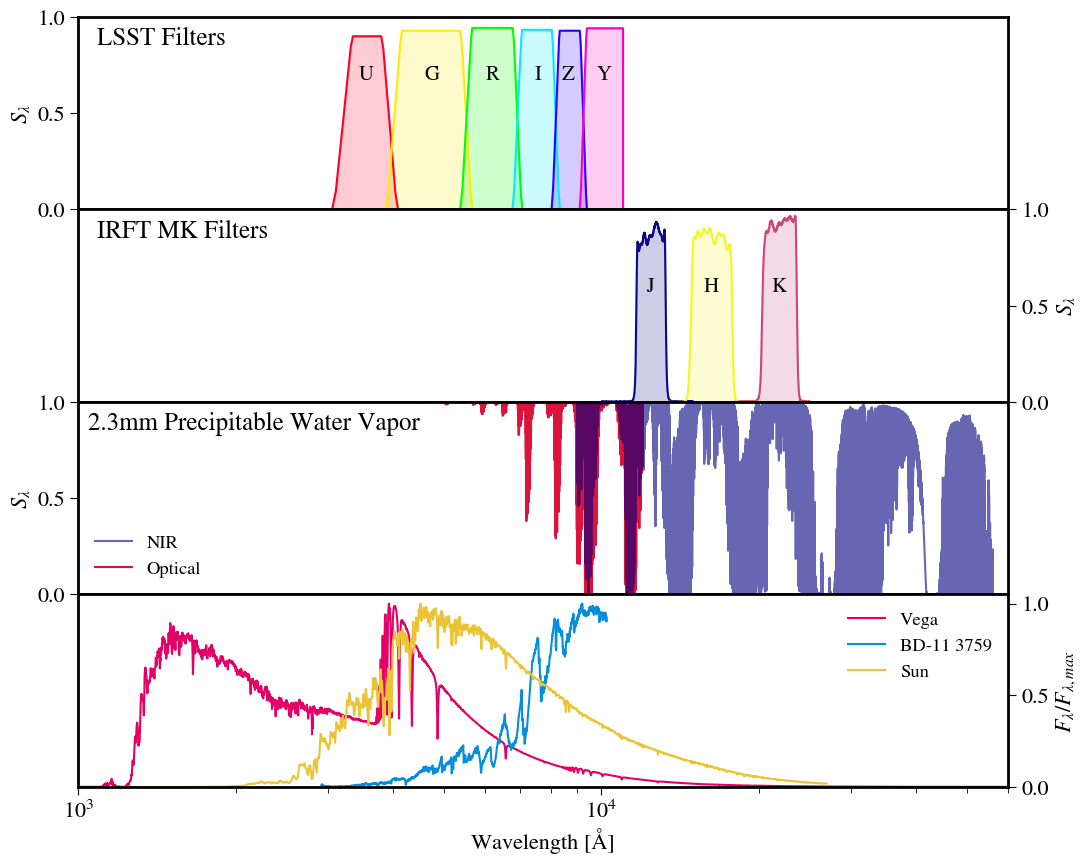

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,10), constrained_layout=False)
plt.subplots_adjust(hspace=0)
plt.xlabel('Wavelength [Å]')
plt.xscale('log')

### LSST filters ###
cmap = plt.get_cmap('gist_rainbow', len(lsst_filters))
colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
for i, key in enumerate(lsst_filters.keys()):
    axes[0].plot(*lsst_filters[key]['raw'], color=colors[i])
    axes[0].fill_between(*lsst_filters[key]['raw'], color=colors[i], alpha=0.2)
axes[0].set_ylabel('$S_λ$')
axes[0].set_ylim(0,1)
axes[0].text(0.02, 0.95, 'LSST Filters', horizontalalignment='left',
             verticalalignment='top', transform=axes[0].transAxes, fontsize=18)
axes[0].text(0.38, 0.7, 'G', horizontalalignment='center',
             verticalalignment='center', transform=axes[0].transAxes, fontsize=15)
axes[0].text(0.565, 0.7, 'Y', horizontalalignment='center',
             verticalalignment='center', transform=axes[0].transAxes, fontsize=15)
axes[0].text(0.445, 0.7, 'R', horizontalalignment='center',
             verticalalignment='center', transform=axes[0].transAxes, fontsize=15)
axes[0].text(0.494, 0.7, 'I', horizontalalignment='center',
             verticalalignment='center', transform=axes[0].transAxes, fontsize=15)
axes[0].text(0.527, 0.7, 'Z', horizontalalignment='center',
             verticalalignment='center', transform=axes[0].transAxes, fontsize=15)
axes[0].text(0.31, 0.7, 'U', horizontalalignment='center',
             verticalalignment='center', transform=axes[0].transAxes, fontsize=15)
axes[0].set_yticks([0, 0.5, 1])
axes[0].tick_params(axis='y', size=6)


### IRTF filters ###
cmap = plt.get_cmap('plasma', len(jhk_filters))
colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
for i, key in enumerate(jhk_filters.keys()):
    d = np.loadtxt(file, skiprows=1)
    axes[1].plot(*jhk_filters[key]['raw'], color=colors[i])
    axes[1].fill_between(*jhk_filters[key]['raw'], color=colors[i], alpha=0.2)
axes[1].set_ylabel('$S_λ$')
axes[1].set_ylim(0,1)
axes[1].text(0.02, 0.95, 'IRFT MK Filters', horizontalalignment='left',
             verticalalignment='top', transform=axes[1].transAxes, fontsize=18)
axes[1].text(0.615, 0.6, 'J', horizontalalignment='center',
             verticalalignment='center', transform=axes[1].transAxes, fontsize=15)
axes[1].text(0.753, 0.6, 'K', horizontalalignment='center',
             verticalalignment='center', transform=axes[1].transAxes, fontsize=15)
axes[1].text(0.68, 0.6, 'H', horizontalalignment='center',
             verticalalignment='center', transform=axes[1].transAxes, fontsize=15)
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.tick_right()
axes[1].set_yticks([0, 0.5, 1])
axes[1].tick_params(axis='y', size=6)


### Water Vapor ###
colors = ['navy', 'crimson']
alphas = [0.6, 1]
labels = ['NIR', 'Optical']
zorders = [None, 0]
for i, key in enumerate(water_filters.keys()):
    axes[2].plot(*water_filters[key]['raw'], alpha=alphas[i], color=colors[i], label=labels[i], zorder=zorders[i])
axes[2].legend()
axes[2].set_ylabel('$S_λ$')
axes[2].set_ylim(0,1)
axes[2].text(0.01, 0.95, '2.3mm Precipitable Water Vapor', horizontalalignment='left',
             verticalalignment='top', transform=axes[2].transAxes, fontsize=18)
axes[2].set_yticks(ticks=[0, 0.5, 1])
axes[2].tick_params(axis='y', size=6)


### SEDs ###
colors = ['#E40066', '#058ED9', '#EAC435']
sed_names = ['Vega', 'BD-11 3759', 'Sun']

for i, key in enumerate(seds.keys()):
    if key == 'alpha':
        name = 'Vega'
    elif key == 'sun':
        name = 'Sun'
    else:
        name = 'BD-11 3759'
    axes[3].plot(seds[key]['raw'][0], seds[key]['raw'][1] / np.max(seds[key]['raw'][1]), label=name, color=colors[i])
axes[3].legend()
axes[3].set_ylabel('$F_λ/F_{λ, max}$')
axes[3].set_ylim(0,1.05)
axes[3].set_yticks([0, 0.5, 1])
axes[3].yaxis.set_label_position('right')
axes[3].yaxis.tick_right()
axes[3].tick_params(axis='y', size=6)

plt.xlim(1e3, 6e4)
plt.tick_params(axis='x', which='major', length=6)
plt.tick_params(axis='x', which='minor', length=4)
plt.show()

## Q3. Combine the filter transmission and your atmosphere transmission - we'll assume the mirror and CCDs are perfect over the entire wavelength range. Implement the integrals for flux and magnitude discussed in Lecture 3 as python code. (40 pts)

- You'll have to do something to `interpolate` measurements continuously across the full wavelength range you have across Optical to NIR (you can ignore the MIR file for now, but you'll want it next week)
- Make sure the units are consistent for both wavelength and transmission before you write your interpolator or address differences in some other way 
- You'll need to make sure your interpolator can match the wavelength spacing of the SEDs in Q2
- Rememeber that the intergrals include the transmission $T(\lambda)$, which is not normalized properly, so make sure to normalize your integral appropriately
- Normalize the synthetic flux in two ways
    1. such as Vega has magnitude 0 in each band.
    2. such that a synthetic AB source has magnitude 0 in each band

Report the magitudes of the Sun and BD-11 3759 in the Vega and AB system, and the AB magnitudes of Vega in a table (columns = passbands, rows = star/system)

- 15 pts each for the Sun and BD-11 3759 (2 pts for the six optical bands, 1 pt each for JHK) 
- 10 pts for the AB mags of Vega (yes, I know there are 9 bands, not 10, but you can have the one extra)

In [11]:
c = 3e18 # [Å/s]
freq_range = c / (lambda_range * 1e-10) # [Hz]

F_ν_AB = 3.631e-20 # [ergs cm^-2 s^-1 Hz^-1] -- from Narayan et al. (2019) 
F_λ_AB = F_ν_AB * (c / lambda_range**2)

In [12]:
passbands = list(lsst_filters.keys()) + list(jhk_filters.keys())
mags = {
    'Passbands':np.array(passbands),
    'Sun (Vega)': [],
    'BD11-3759 (Vega)':[] ,
    'Vega (Vega)': [],
    'Sun (AB)': [],
    'BD11-3759 (AB)': [],
    'Vega (AB)': []
}

In [13]:
# Get magnitudes relative to AB
for name in seds.keys():
    for key in lsst_filters.keys():
        fp = np.sum(np.prod([seds[name]['interp'](lambda_range), lsst_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        fab = np.sum(np.prod([F_λ_AB, lsst_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        m = -2.5*np.log10(fp/fab)
        if name == 'sun':
            mags['Sun (AB)'].append(m)
        elif name == 'alpha':
            mags['Vega (AB)'].append(m)
        else:
            mags['BD11-3759 (AB)'].append(m)
    for key in jhk_filters.keys():
        fp = np.sum(np.prod([seds[name]['interp'](lambda_range), jhk_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        fab = np.sum(np.prod([F_λ_AB, jhk_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        m = -2.5*np.log10(fp/fab)
        if np.isinf(m):
            m = np.nan
        if name == 'sun':
            mags['Sun (AB)'].append(m)
        elif name == 'alpha':
            mags['Vega (AB)'].append(m)
        else:
            mags['BD11-3759 (AB)'].append(m)

/var/folders/6g/rhh3qqdd06l257mlr24x9y580000gn/T/ipykernel_4631/2855523112.py:16: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(fp/fab)
/var/folders/6g/rhh3qqdd06l257mlr24x9y580000gn/T/ipykernel_4631/2855523112.py:16: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(fp/fab)


In [14]:
# Get magnitudes relative to Vega
for name in seds.keys():
    for key in lsst_filters.keys():
        fp = np.sum(np.prod([seds[name]['interp'](lambda_range), lsst_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        fab = np.sum(np.prod([seds['alpha']['interp'](lambda_range), lsst_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        m = -2.5*np.log10(fp/fab)
        if name == 'sun':
            mags['Sun (Vega)'].append(m)
        elif name == 'alpha':
            mags['Vega (Vega)'].append(m)
        else:
            mags['BD11-3759 (Vega)'].append(m)
    
    for key in jhk_filters.keys():
        fp = np.sum(np.prod([seds[name]['interp'](lambda_range), jhk_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        fab = np.sum(np.prod([seds['alpha']['interp'](lambda_range), jhk_filters[key]['interp'](lambda_range), water_tot_filter], axis=0))
        m = -2.5*np.log10(fp/fab)
        if np.isinf(m):
            m = np.nan
        if name == 'sun':
            mags['Sun (Vega)'].append(m)
        elif name == 'alpha':
            mags['Vega (Vega)'].append(m)
        else:
            mags['BD11-3759 (Vega)'].append(m)
    

/var/folders/6g/rhh3qqdd06l257mlr24x9y580000gn/T/ipykernel_4631/742021260.py:17: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(fp/fab)
/var/folders/6g/rhh3qqdd06l257mlr24x9y580000gn/T/ipykernel_4631/742021260.py:17: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(fp/fab)


In [15]:
df = pd.DataFrame(mags)
df

,Passbands,Sun (Vega),BD11-3759 (Vega),Vega (Vega),Sun (AB),BD11-3759 (AB),Vega (AB)
0,u,-26.062808,14.013502,-0.0,-25.189147,14.887164,0.873662
1,g,-26.342136,12.259786,-0.0,-26.447541,12.154381,-0.105405
2,r,-27.064928,10.586353,-0.0,-26.924332,10.726948,0.140596
3,i,-27.409498,8.840234,-0.0,-27.038753,9.210979,0.370745
4,z,-27.573427,7.955565,-0.0,-27.059051,8.469941,0.514376
5,y,-27.663965,8.104977,-0.0,-27.054655,8.714287,0.609310
6,j,-27.939761,NaN,-0.0,-27.011292,NaN,0.928469
7,k,-28.300502,NaN,-0.0,-26.409954,NaN,1.890548
8,h,-28.245353,NaN,-0.0,-26.881076,NaN,1.364277


### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Sep 17 at Noon!